## SentenceTransformers

In [1]:
import pandas as pd
import numpy as np

from IPython.display import Markdown, display

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### Understanding Embeddings and Similarities

In [2]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# The sentences to encode
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(sentences)
print(embeddings.shape)
# [3, 384]

# 3. Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
similarities

2025-03-02 21:52:29.242041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(3, 384)


tensor([[1.0000, 0.6660, 0.1046],
        [0.6660, 1.0000, 0.1411],
        [0.1046, 0.1411, 1.0000]])

**Similarities are basically covariance between pairs of "words" (embeddings) in document**

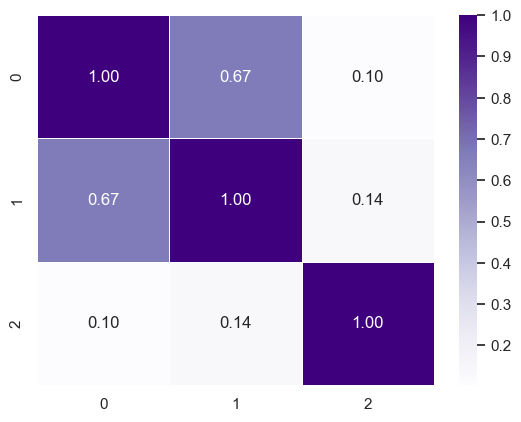

In [3]:
sns.heatmap(similarities, annot=True, fmt='.2f', linewidth=.5, cmap='Purples');

In [4]:
del model, sentences, embeddings, similarities

### Compare Performance of Sentence Transformers on Wine Review Data Set

#### Load Data

In [5]:
df = pd.read_parquet('files/wine_review.parquet.gzip')
df.head()


,country,description,points,price,taster_name,title,variety,winery,year,wine_style,type,quality,classification,location,band,preprocessed_description
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013,light_white,white,medium,Old World,Etna,None,include tropical fruit broom brimstone dry h...
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,medium_red,red,medium,Old World,Douro,popular,do ripe fruity wine smooth structure firm tann...
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,light_white,white,medium,New World,Oregon,popular,rainstorm snappy flavor lime flesh rind domina...
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,aromatic_white,white,medium,New World,Michigan,popular,rind lemon pith orange blossom start aroma pal...
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,light_red,red,medium,New World,Oregon,luxury,vintner like regular bottling come rough tanni...


**Define the Corpus to Transform**

In [6]:
# The sentences to encode
sentences = df.description.to_list()
sentences[:5]

["Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",
 "This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.",
 'Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.',
 'Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.',
 "Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy count

#### Define Helper Functions

**Helper to Time Various Operations**

In [7]:
import time
from collections import namedtuple

PERF = namedtuple('PERF', ['algo', 'duration'])

timings = []

def timeit(algo, purpose, func, count, items='documents'):
  start = time.perf_counter()
  result = func()
  elapsed = time.perf_counter()-start
  timings.append(PERF(algo, elapsed))
  display(Markdown(f'It took ${elapsed/60:.1f}$ minutes to {purpose} for ${count:,d}$ {items}.'))
  return result

**Helper to Compute Embeddings for a Corpus Given the Name of a Pretrained Model**

In [8]:
from sentence_transformers import SentenceTransformer

def compute_embeddings(corpus, model_name='all-MiniLM-L6-v2'):
  # timing helper
  __t = lambda purpose, func: timeit(model_name, purpose, func, len(corpus), 'reviews')

  # calculate embeddings using a pretrained sentence transformer model
  model = SentenceTransformer(model_name)
  return __t('compute embeddings', lambda: model.encode(corpus, normalize_embeddings=True, show_progress_bar=True, device='mps'))

**Helper to compute the t-SNE Dimensional Reduction of Embeddings Vector**

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from joblib import Parallel, delayed, parallel_config

def tsne(embeddings, perplexity=10):
  # timing helper
  __t = lambda purpose, func: timeit('tsne', purpose, func, embeddings.shape[0], 'reviews')

  # perform dimensionsal reduction on features extracted by sentence transformers
  pca = PCA(n_components=50, random_state=42)
  tsne = TSNE(perplexity=perplexity, random_state=42, n_jobs=1)
  return __t('perform t-SNE dimension reduction on embeddings', lambda: tsne.fit_transform(pca.fit_transform(embeddings)))


**Helper to Plot the Result of the Dimensional Reduction**

In [10]:
color_map = dict(
  sparkling='forestgreen',
  white='gold',
  rose='deeppink',
  red='darkred',
  dessert='dodgerblue',
)

def visualize_embeddings(tsne_result, df=df, model_name='all-MiniLM-L6-v2', hue=None):
  # Create a scatter plot with colors based on variet
  sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], s=0.35, hue=hue, palette=None if hue is None else color_map) #, c='type', cmap='viridis')
  plt.title(f'2D t-SNE Plot of {model_name} Embeddings')
  if hue is not None:
    plt.legend(title=None, loc='lower center', mode='expand', ncol=df.type.shape[0], frameon=False, fancybox=False, markerscale=10, 
              fontsize='small', bbox_to_anchor=(.0,-0.05,0.9,1), title_fontsize='medium', handletextpad=.45)
  plt.axis("off")
  plt.show()

#### Evaluate Various Pretrained Sentence Transformer Models** 

**`all-MiniLM-L6-v2` Model with 384 dimensions**

In [11]:
# compute embeddings and similarities vectors
minilm_l6_embeddings = compute_embeddings(sentences, model_name='all-MiniLM-L6-v2')
minilm_l6_embeddings.shape

Batches:   0%|          | 0/3142 [00:00<?, ?it/s]

It took $3.8$ minutes to compute embeddings for $100,538$ reviews.

(100538, 384)

In [12]:
minilm_l6_tsne = tsne(minilm_l6_embeddings)
minilm_l6_tsne.shape

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


It took $5.3$ minutes to perform t-SNE dimension reduction on embeddings for $100,538$ reviews.

(100538, 2)

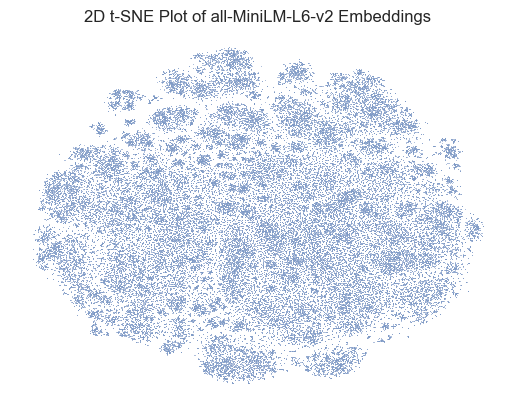

In [13]:
visualize_embeddings(minilm_l6_tsne, model_name='all-MiniLM-L6-v2')

**`all-mpnet-base-v2` Model with 768 dimensions**

In [14]:
# compute embeddings and similarities vectors
mpnet_embeddings = compute_embeddings(sentences, 'all-mpnet-base-v2')
mpnet_embeddings.shape


Batches:   0%|          | 0/3142 [00:00<?, ?it/s]

It took $104.8$ minutes to compute embeddings for $100,538$ reviews.

(100538, 768)

In [15]:
mpnet_tsne = tsne(mpnet_embeddings)
mpnet_tsne.shape

It took $4.8$ minutes to perform t-SNE dimension reduction on embeddings for $100,538$ reviews.

(100538, 2)

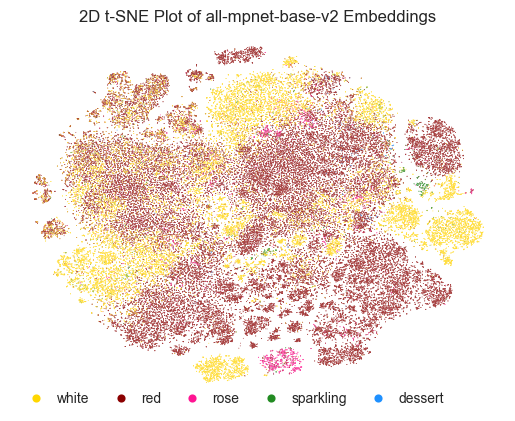

In [18]:
visualize_embeddings(mpnet_tsne, model_name='all-mpnet-base-v2', hue=df.type)

**`jina-embeddings-v2-base-en` Model with Tunable Dimensions**

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True) # trust_remote_code is needed to use the encode method
jina_embeddings = timeit('jina-embeddings-v2-base-en', 'compute embeddings', lambda: model.encode(sentences, normalize_embeddings=True, show_progress_bar=True, device='cpu', max_length=2048), len(sentences), 'reviews')
jina_embeddings.shape

TypeError: 'int' object is not callable

In [ ]:
jina_tsne = tsne(jina_embeddings)
jina_tsne.shape

It took $5.2$ minutes to perform t-SNE dimension reduction on embeddings for $100,538$ reviews.

(100538, 2)

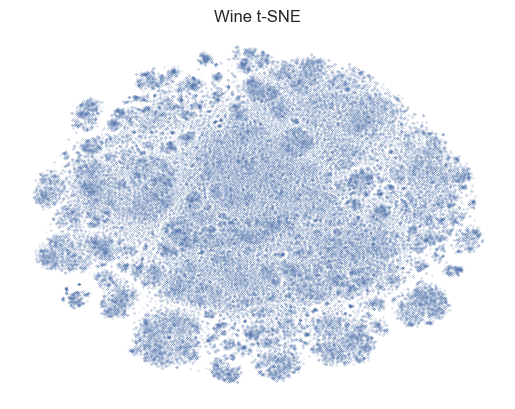

In [ ]:
visualize_embeddings(jina_tsne, model_name='jina-embeddings-v2-base-en')

**`all-MiniLM-L12-v2` Model with 384 dimensions**

In [ ]:
# compute embeddings and similarities vectors
minilm_l12_embeddings = compute_embeddings(sentences, "all-MiniLM-L12-v2")
minilm_l12_embeddings.shape

Batches:   0%|          | 0/3142 [00:00<?, ?it/s]

It took $5.5$ minutes to compute embeddings for $100,538$ reviews.

(100538, 384)

In [ ]:
minilm_l12_tsne = tsne(minilm_l12_embeddings)
minilm_l12_tsne.shape

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


It took $4.8$ minutes to perform t-SNE dimension reduction on embeddings for $100,538$ reviews.

(100538, 2)

In [ ]:
minilm_l12_tsne.shape

(100538, 2)

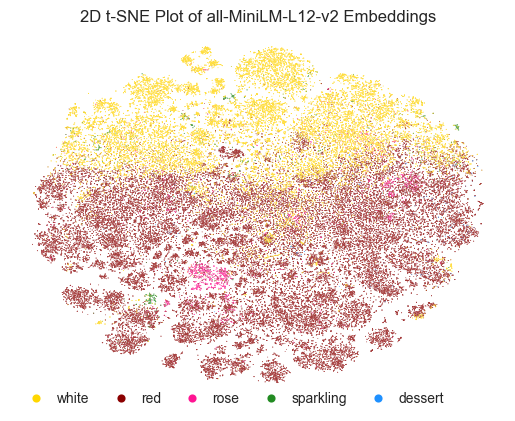

In [ ]:
visualize_embeddings(minilm_l12_tsne, model_name="all-MiniLM-L12-v2")

### Evaluate Performance

In [ ]:
timings

[PERF(algo='all-MiniLM-L12-v2', duration=330.6847363419947),
 PERF(algo='tsne', duration=289.5517140360316)]